# Deep Learning-based MRI Reconstruction

This tutorial demonstrates how to reconstruct undersampled MRI data using deep learning techniques. It includes theoretical foundations alongside practical implementation in Python using PyTorch.

MRI reconstruction aims to convert raw k-space data into clinically interpretable images. Deep learning offers a data-driven solution to this problem, leveraging models trained to map undersampled data to fully reconstructed images.

In this tutorial, we'll cover the following topics:
1. Loading and visualizing a MRI sample
2. Understanding k-space
- Fourier transform and visualization of k-space data
- Undersampling patterns
- Simulating undersampling in k-space
3. Training an end-to-end MRI reconstruction model
- Defining the network architecture
- Setting up the data pipeline
- Defining the loss function
- Training the model
- Evaluating the model on test data


## Before We Start


### Install Required Libraries

In [2]:
pass

### Import Required Libraries

Let's start by importing the required libraries.

In [3]:
import os
import h5py
import numpy as np
import random
from glob import glob
from scipy.fftpack import fftshift, ifftshift, fftn, ifftn
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils import spectral_norm
from torch.nn import functional as F
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


### Set Working Path (for Google Colab)

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Path to the directory containing the data
# path = './gdrive/MyDrive/Share/MRI_RECON_TUTORIAL/simple_mri_recon/' 
# os.chdir(path)

### Setup Random Seed

We'll set a random seed for reproducibility.

In [5]:
# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


### Setup Device

We'll check if a GPU is available and set the device accordingly.

In [6]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


### Some Utility Functions

Let's define some utility functions that we'll use throughout the tutorial.

In [7]:
# Create directory
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)


## Load and Visualize a Sample

MRI data is loaded in .h5 format, containing complex-valued images. Magnitude and phase components are extracted for visualization. The magnitude and phase images reveal important structural and phase information, offering insights into the data quality and characteristics.


In [8]:
# Load H5 file
def read_processed_h5(data_path):
    with h5py.File(data_path, 'r') as file:
        data = {
            'image_complex': file['image_complex'][()],
            'data_name': file['image_complex'].attrs['data_name'],
            'slice_idx': file['image_complex'].attrs['slice_idx'],
        }
    return data


In [9]:
# Normalisation
def preprocess_normalisation(img, type):
    if type == 'complex_mag':
        img = img / np.abs(img).max()
    elif type == '0_1':
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
    else:
        raise NotImplementedError

    return img


In [10]:
# Load H5 data
sample_data = read_processed_h5('sample/file1000031_000.h5')

# Load complex MR data
image_complex = sample_data['image_complex']

# Do normalisation
image_complex_norm = preprocess_normalisation(image_complex, type='complex_mag')

# Show some information before and after normalisation
print("Data Shape: {}; Data Type: {}; "
      "Data Range (before normalisation): {:.3e}~{:.3e}; "
      "Data Range (after normalisation): {:.3e}~{:.3e}".format(image_complex.shape, 
                                                               image_complex.dtype, 
                                                               abs(image_complex).min(), 
                                                               abs(image_complex).max(), 
                                                               abs(image_complex_norm).min(), 
                                                               abs(image_complex_norm).max(),))


Data Shape: (320, 320); Data Type: complex64; Data Range (before normalisation): 2.505e-10~3.907e-07; Data Range (after normalisation): 6.411e-04~1.000e+00


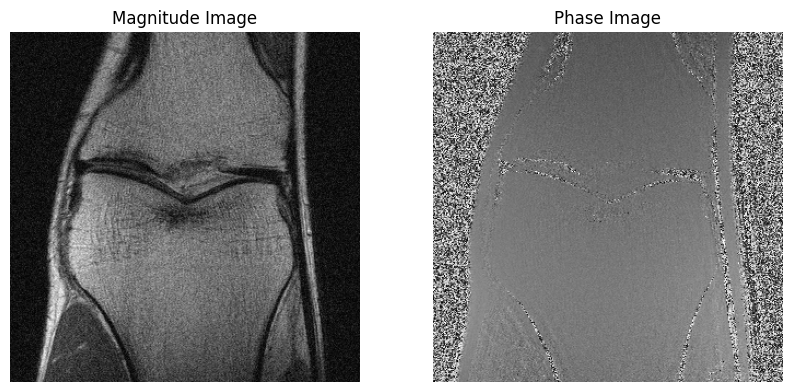

In [11]:
# Extract components: magnitude and phase
image_magnitude = np.abs(image_complex_norm)
image_phase = np.angle(image_complex_norm)

# Plot the images
plt.figure(figsize=(10, 10))
# Magnitude image
plt.subplot(2, 2, 1)
plt.imshow(image_magnitude, cmap='gray')
plt.title('Magnitude Image')
plt.axis('off')
# Phase image
plt.subplot(2, 2, 2)
plt.imshow(image_phase, cmap='gray')
plt.title('Phase Image')
plt.axis('off')
plt.show()


## K-Space Fundamentals

### Fourier Transform

K-space is the frequency domain representation of MRI data. Visualizing k-space in both 2D and 3D provides insights into frequency content. Forward and inverse Fourier transforms allow switching between image and k-space domains, enabling operations like undersampling.


In [12]:
def plot_kspace_and_mesh(kspace_magnitude):
    kspace_magnitude_clip_for_vis = np.clip(kspace_magnitude, 0, np.percentile(kspace_magnitude, 99.9))

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Plot 2D k-space magnitude
    axes[0].imshow(kspace_magnitude_clip_for_vis, cmap='gray')
    axes[0].set_title('K-Space Magnitude')
    axes[0].axis('off')

    # Plot 3D Mesh of the k-space magnitude
    x = np.arange(kspace_magnitude_clip_for_vis.shape[1])
    y = np.arange(kspace_magnitude_clip_for_vis.shape[0])
    x, y = np.meshgrid(x, y)

    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(x, y, kspace_magnitude_clip_for_vis, cmap='viridis')
    ax.set_title('3D Mesh of K-Space Magnitude')

    plt.show()


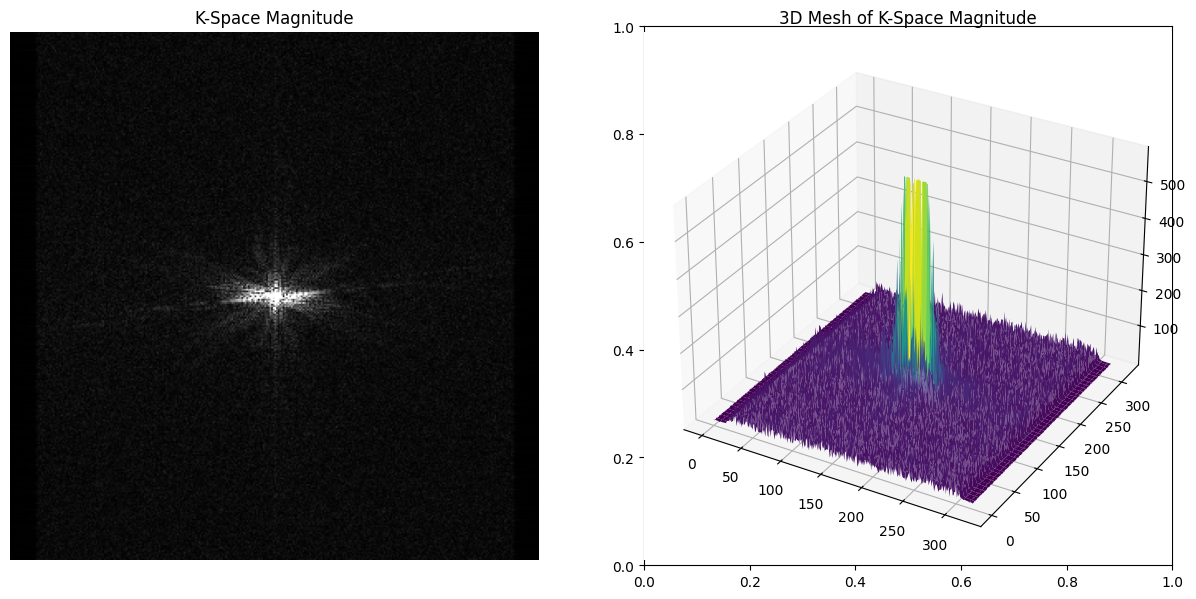

In [13]:
# Perform FFT to acquire k-space
kspace_complex = fftshift(fftn(ifftshift(image_complex_norm), axes=(-2, -1)))

# Plot the k-space 
kspace_magnitude = np.abs(kspace_complex)
plot_kspace_and_mesh(kspace_magnitude)


### K-space Undersampling Pattern

Undersampling masks, such as GRAPPA-like or random Gaussian, are loaded. These masks define the specific sampling patterns applied to k-space data, simulating accelerated acquisition.


In [14]:
# Undersampling mask selection
def define_mask(mask_name):

    # GRAPPA-like (with ACS) Regular Acceleration Factor x Central Fraction x PE (from fastMRI)
    if mask_name == 'fMRI_Reg_AF2_CF0.16_PE320':
        mask_1d = np.load(os.path.join('mask', 'fastmri', 'regular', 'regular_af2_cf0.16_pe320.npy'))
    elif mask_name == 'fMRI_Reg_AF4_CF0.08_PE320':
        mask_1d = np.load(os.path.join('mask', 'fastmri', 'regular', 'regular_af4_cf0.08_pe320.npy'))
    elif mask_name == 'fMRI_Reg_AF8_CF0.04_PE320':
        mask_1d = np.load(os.path.join('mask', 'fastmri', 'regular', 'regular_af8_cf0.04_pe320.npy'))
    elif mask_name == 'fMRI_Reg_AF16_CF0.02_PE320':
        mask_1d = np.load(os.path.join('mask', 'fastmri', 'regular', 'regular_af16_cf0.02_pe320.npy'))

    # GRAPPA-like (with ACS) Random (Gaussian) Acceleration Factor x Central Fraction x PE (from fastMRI)
    elif mask_name == 'fMRI_Ran_AF2_CF0.16_PE320':
        mask_1d = np.load(os.path.join('mask', 'fastmri', 'random', 'random_af2_cf0.16_pe320.npy'))
    elif mask_name == 'fMRI_Ran_AF4_CF0.08_PE320':
        mask_1d = np.load(os.path.join('mask', 'fastmri', 'random', 'random_af4_cf0.08_pe320.npy'))
    elif mask_name == 'fMRI_Ran_AF8_CF0.04_PE320':
        mask_1d = np.load(os.path.join('mask', 'fastmri', 'random', 'random_af8_cf0.04_pe320.npy'))
    elif mask_name == 'fMRI_Ran_AF16_CF0.02_PE320':
        mask_1d = np.load(os.path.join('mask', 'fastmri', 'random', 'random_af16_cf0.02_pe320.npy'))
    
    else:
        raise NotImplementedError
    
    mask_1d = mask_1d[:, np.newaxis]
    mask = np.repeat(mask_1d, 320, axis=1).transpose((1, 0))
    
    return mask


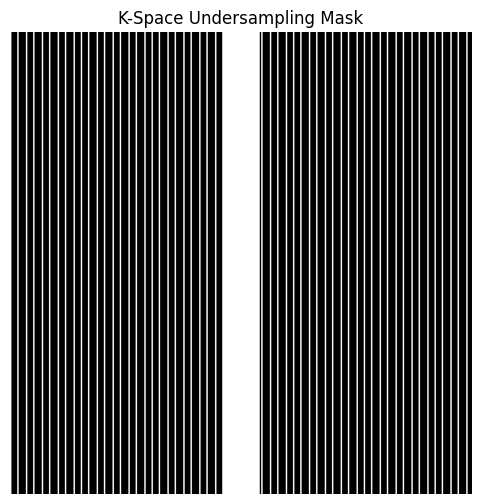

In [15]:
# Load k-space undersampling pattern
mask = define_mask(mask_name='fMRI_Reg_AF4_CF0.08_PE320')

# Plot the mask
plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap='gray')
plt.title('K-Space Undersampling Mask')
plt.axis('off')
plt.show()


### K-space Undersampling

The undersampling mask is applied to the fully sampled k-space data. This step simulates accelerated MRI acquisition, introducing aliasing artifacts. An inverse FFT reconstructs the image from undersampled k-space data, revealing the extent of artifacts caused by undersampling.


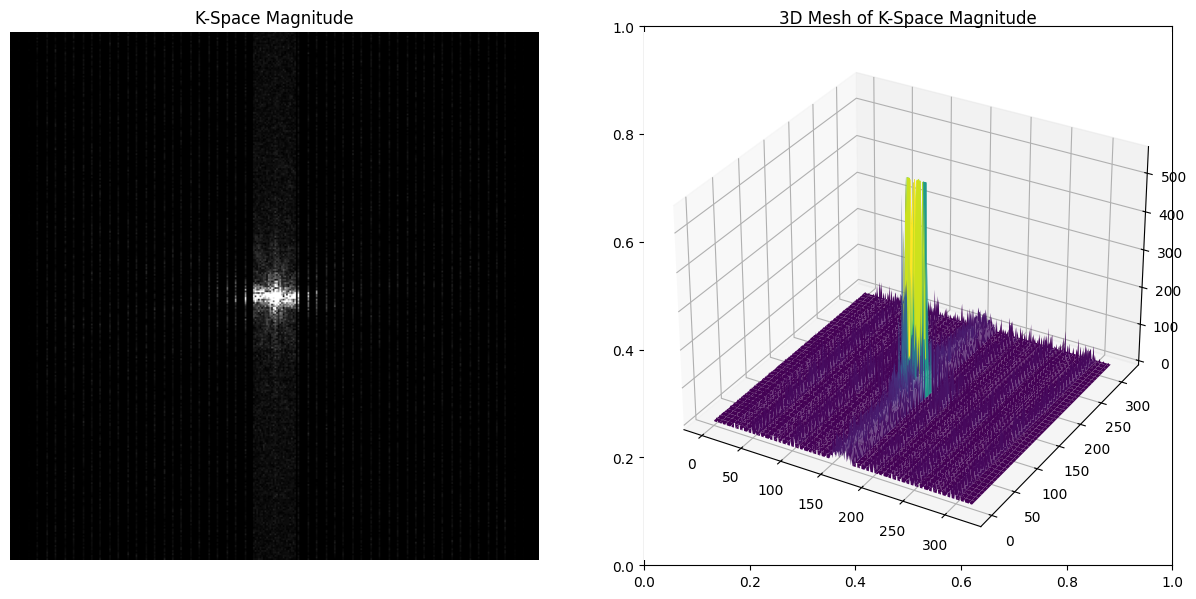

In [16]:
# k-space undersampling
undersampled_kspace_complex = kspace_complex * mask

# Plot the undersampled k-space 
undersampled_kspace_magnitude = np.abs(undersampled_kspace_complex)
plot_kspace_and_mesh(undersampled_kspace_magnitude)


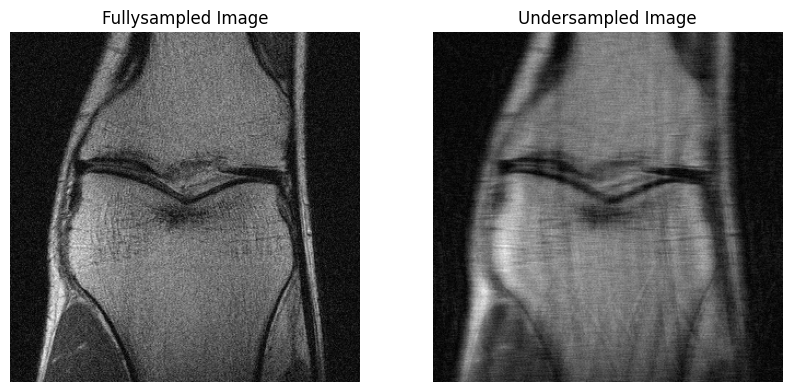

In [17]:
# Perform Inverse FFT to acquire the undersampled image
undersampled_image_complex = fftshift(ifftn(ifftshift(undersampled_kspace_complex), axes=(-2, -1)))

# Extract components: magnitude, phase images
undersampled_image_magnitude = np.abs(undersampled_image_complex)
undersampled_image_phase = np.angle(undersampled_image_complex)

# Plot the images
plt.figure(figsize=(10, 10))
# Fullysampled image
plt.subplot(2, 2, 1)
plt.imshow(image_magnitude, cmap='gray')
plt.title('Fullysampled Image')
plt.axis('off')
# Undersampled image
plt.subplot(2, 2, 2)
plt.imshow(undersampled_image_magnitude, cmap='gray')
plt.title('Undersampled Image')
plt.axis('off')
plt.show()


## Training an End-to-end MRI Reconstruction Model

Deep learning models, particularly U-Net variants, are employed for reconstructing undersampled MRI images. This section details the model definition, data preparation, and training steps.

In a deep learning-based MRI reconstruction pipeline, the input and target are critical for training the model:

- **Input**: The undersampled MRI image or k-space data. This is generated by applying an undersampling mask to the fully sampled k-space data. For training, the input is typically represented in the image domain as two channels: real and imaginary components of the complex-valued image.

- **Target**: The fully sampled MRI image or k-space data, representing the ground truth. Like the input, the target is often stored in the image domain with real and imaginary components.

The goal of training is for the model to learn a mapping from the undersampled input to the fully reconstructed target.


### Delete the previous variables


In [18]:
del image_complex, image_complex_norm, image_magnitude, image_phase
del kspace_complex, kspace_magnitude, undersampled_kspace_complex, undersampled_kspace_magnitude
del undersampled_image_complex, undersampled_image_magnitude, undersampled_image_phase
del sample_data
del mask


### Parameters


In [19]:
# Parameters

## Task 
model_name = 'unet'
# model_name = 'unet_resi'
mask_name = 'fMRI_Reg_AF4_CF0.08_PE320'

is_debug = False
is_save_models = True
is_save_all_models = False
is_skip_training = False
pretrained_model_path = None
# pretrained_model_path = 'weight/unet_fMRI_Reg_AF4_CF0.08_PE320/unet.pth'

task_name = '{}_{}'.format(model_name, mask_name) if not is_debug else 'tmp'
save_path = os.path.join('runs', task_name)

## Dataset
train_path = 'dataset/fastmri_tiny/train'
test_path = 'dataset/fastmri_tiny/val'
train_batch_size = 4
test_batch_size = 1

## Model
in_channels = 2
out_channels = 2

## Optimisation
total_epochs = 100
lr = 1e-4

## Parameter check
assert is_skip_training == (pretrained_model_path is not None)  # is_skip_training implies pretrained_model_path is not None
assert not is_save_all_models or is_save_models  # is_save_all_models implies is_save_models


### Define Network


In [20]:
# U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2, 2)
        self.middle = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        m = self.middle(self.pool(e4))

        d4 = self.up4(m)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.decoder4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.decoder1(d1)

        out = self.final(d1)
        
        return out


In [21]:
# U-Net model with skip connections
class UNet_resi(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet_resi, self).__init__()
        
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2, 2)

        self.middle = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        m = self.middle(self.pool(e4))

        d4 = self.up4(m)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.decoder4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.decoder1(d1)

        out = self.final(d1)
        
        return out + x

In [22]:
# Network selection
def define_model(model_name):

    if model_name == 'unet':
        model_type = UNet
    elif model_name == 'unet_resi':
        model_type = UNet_resi
    else:
        raise NotImplementedError
    
    return model_type


In [23]:
# Load the model
model_type = define_model(model_name)

# Instantiate the model
model = model_type(in_channels=in_channels, out_channels=out_channels).to(device)


### Define Dataloader


In [24]:
# k-space undersampling
def undersample_kspace(x, mask):

    fft = fftshift(fftn(ifftshift(x, axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))
    fft = fft * mask
    x = fftshift(ifftn(ifftshift(fft, axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))

    return x


# Data loader
class DatasetFastMRI(Dataset):

    def __init__(self, data_path_src, mask_name, is_debug=False):
        super(DatasetFastMRI, self).__init__()

        # get undersampling mask
        self.mask = define_mask(mask_name)

        # get data path
        self.data_paths = glob(os.path.join(data_path_src, '*.h5'))
        
        # for debug
        self.data_paths = self.data_paths[:12] if is_debug else self.data_paths

    def __getitem__(self, index):
        
        # get undersampling mask
        mask = self.mask  # H, W

        # get gt image
        H_path = self.data_paths[index]

        # read h5
        img_dict = read_processed_h5(H_path)

        # get complex image
        img_H_SC = img_dict['image_complex']

        # normalisation
        img_H_SC = preprocess_normalisation(img_H_SC, type='complex_mag')

        # get zf image
        img_L_SC = undersample_kspace(img_H_SC, mask)

        # expand dim
        img_H_SC = img_H_SC[:, :, np.newaxis]  # H, W, 1
        img_L_SC = img_L_SC[:, :, np.newaxis]  # H, W, 1

        # Complex --> 2CH
        img_H_SC = np.concatenate((np.real(img_H_SC), np.imag(img_H_SC)), axis=-1)  # H, W, 2
        img_L_SC = np.concatenate((np.real(img_L_SC), np.imag(img_L_SC)), axis=-1)  # H, W, 2

        # HWC to CHW, numpy to tensor
        img_L_SC = torch.from_numpy(np.ascontiguousarray(img_L_SC)).permute(2, 0, 1).to(torch.float32)
        img_H_SC = torch.from_numpy(np.ascontiguousarray(img_H_SC)).permute(2, 0, 1).to(torch.float32)

        return img_L_SC, img_H_SC   

    def __len__(self):
        return len(self.data_paths)


In [25]:
# Training and testing dataloaders
train_dataset = DatasetFastMRI(data_path_src=train_path, mask_name=mask_name, is_debug=is_debug)
test_dataset = DatasetFastMRI(data_path_src=test_path, mask_name=mask_name, is_debug=is_debug)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=False)


### Define Loss Function


In [26]:
# Loss selection
def define_loss(loss_type):

    if loss_type == 'l1':
        lossfn = nn.L1Loss()
    elif loss_type == 'l2':
        lossfn = nn.MSELoss()
    else:
        raise NotImplementedError
    
    return lossfn


# FFT for frequency loss
def fft_map(x):
    fft_x = torch.fft.fftn(x)
    fft_x_real = fft_x.real
    fft_x_imag = fft_x.imag

    return fft_x_real, fft_x_imag


# Total loss
def total_loss(predict, 
               target, 
               loss_image_weight=15,
               loss_image_type='l1',
               loss_freq_weight=0.1, 
               loss_freq_type='l1',
               device='cpu'):


    lossfn_image = define_loss(loss_image_type).to(device)
    loss_image = lossfn_image(predict, target)
    
    lossfn_freq = define_loss(loss_freq_type).to(device)
    target_k_real, target_k_imag = fft_map(target)
    predict_k_real, predict_k_imag = fft_map(predict)
    loss_freq = (lossfn_freq(predict_k_real, target_k_real) + lossfn_freq(predict_k_imag, target_k_imag)) / 2

    return loss_image_weight * loss_image + loss_freq_weight * loss_freq 

# Define loss function
loss_fn = partial(total_loss, 
                  loss_image_weight=15,
                  loss_image_type='l1',
                  loss_freq_weight=0.1, 
                  loss_freq_type='l1',
                  device=device)


### Define Optimisation Setting


In [27]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


### Training Loop


In [28]:
# Training for one epoch
def train_one_epoch(model, dataloader, optimizer, loss_fn, epoch, total_epochs):
    model.train()
    total_loss = 0
    all_batch_losses = []
    for batch in tqdm(dataloader, desc=f"Training Epoch {epoch+1}/{total_epochs}", leave=False):
        input, gt = batch
        input, gt = input.to(device), gt.to(device)
        optimizer.zero_grad()
        pred = model(input)
        loss = loss_fn(pred, gt)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        all_batch_losses.append(loss.item())
    return total_loss / len(dataloader), all_batch_losses


Start training


Training Completed


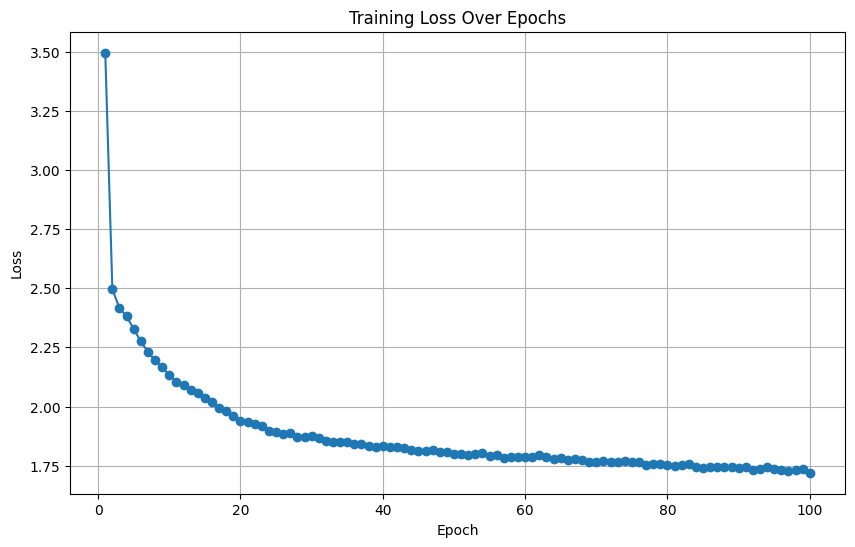

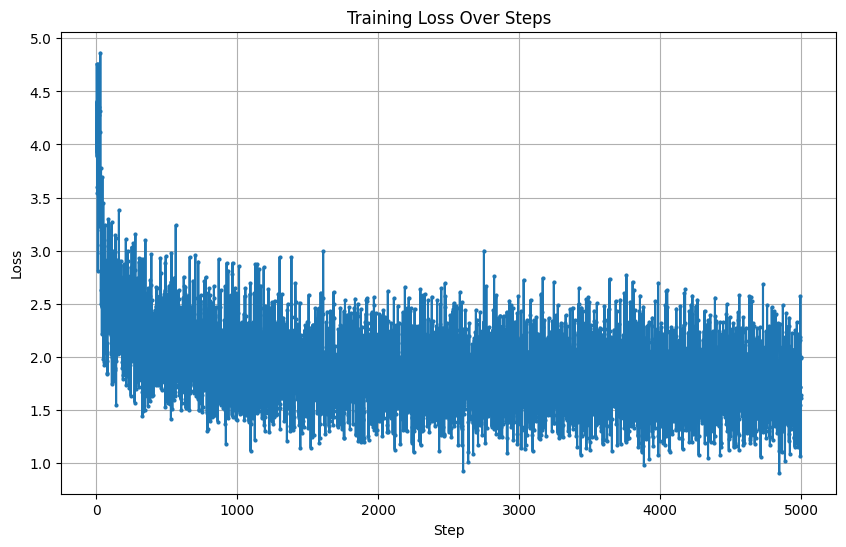

In [29]:
# Skip training
if is_skip_training:
    print("Skip training")
else:
    print("Start training")

    train_losses_over_epochs = []
    train_losses_over_steps = []
    
    # Training loop
    for epoch in range(total_epochs):
        # print(f"Epoch {epoch+1}")
        train_loss, batch_losses = train_one_epoch(model, train_loader, optimizer, loss_fn, epoch, total_epochs)
        train_losses_over_epochs.append(train_loss)
        train_losses_over_steps.extend(batch_losses)
        # print(f"  Training Loss = {train_loss:.4f}")
        
        # save model
        mkdir(save_path)
        if is_save_models:
            torch.save(model.state_dict(), os.path.join(save_path, f"{model_name}.pth"))
            if is_save_all_models:
                torch.save(model.state_dict(), os.path.join(save_path, f"{model_name}_{epoch+1}.pth"))
    
    print("Training Completed")
    
    # Plot training loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses_over_epochs) + 1), train_losses_over_epochs, marker='o')
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()
    
    # Plot training loss over steps
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses_over_steps) + 1), train_losses_over_steps, marker='o', markersize=2)
    plt.title("Training Loss Over Steps")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()


### Metrics 

In [30]:
# PSNR
def calculate_psnr_single(img1, img2, data_range=None):

    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    return peak_signal_noise_ratio(img1, img2, data_range=data_range)

# SSIM
def calculate_ssim_single(img1, img2, data_range=None):
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    return structural_similarity(img1, img2, data_range=data_range)


### Inference


In [31]:
# Validation for testset
def validate(model, dataloader):
    model.eval()

    metrics_dict = {}
    metrics_dict['ssim'] = []
    metrics_dict['psnr'] = []
    metrics_dict['ssim_zf'] = []
    metrics_dict['psnr_zf'] = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation", leave=False):
            input, gt = batch
            input, gt = input.to(device), gt.to(device)
            pred = model(input)

            input = torch.abs(torch.complex(input[:, :1, ...], input[:, 1:, ...]))
            pred = torch.abs(torch.complex(pred[:, :1, ...], pred[:, 1:, ...]))
            gt = torch.abs(torch.complex(gt[:, :1, ...], gt[:, 1:, ...]))
            
            input = input.squeeze().float().cpu().numpy()
            pred = pred.data.squeeze().float().cpu().numpy()
            gt = gt.data.squeeze().float().cpu().numpy()
            
            ssim = calculate_ssim_single(pred, gt, data_range=gt.max())
            psnr = calculate_psnr_single(pred, gt, data_range=gt.max())
            metrics_dict['ssim'].append(ssim)
            metrics_dict['psnr'].append(psnr)
            
            ssim_zf = calculate_ssim_single(input, gt, data_range=gt.max())
            psnr_zf = calculate_psnr_single(input, gt, data_range=gt.max())
            metrics_dict['ssim_zf'].append(ssim_zf)
            metrics_dict['psnr_zf'].append(psnr_zf)
            
    return metrics_dict


# Validation for one step (plotting)
def validate_one_step(model, dataloader):
    model.eval()

    with torch.no_grad():
        batch = next(iter(dataloader))  # Load the first batch
        x, y = batch
        x, y = x.to(device), y.to(device)
        pred = model(x)

        # Visualize the first sample in the batch
        input_image = torch.abs(torch.complex(x[0, 0, :, :], x[0, 1, :, :])).cpu().numpy()
        ground_truth = torch.abs(torch.complex(y[0, 0, :, :], y[0, 1, :, :])).cpu().numpy()
        predicted_image = torch.abs(torch.complex(pred[0, 0, :, :], pred[0, 1, :, :])).cpu().numpy()

        plt.figure(figsize=(15, 5))

        # Input
        plt.subplot(1, 3, 1)
        plt.imshow(input_image, cmap='gray')
        plt.title("Input")
        plt.axis('off')

        # Prediction
        plt.subplot(1, 3, 2)
        plt.imshow(predicted_image, cmap='gray')
        plt.title("Prediction")
        plt.axis('off')
        
        # Ground Truth
        plt.subplot(1, 3, 3)
        plt.imshow(ground_truth, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')
        plt.show()


Validation SSIM: 0.6592
Validation PSNR: 28.4591
Validation SSIM (ZF): 0.6066
Validation PSNR (ZF): 26.1458


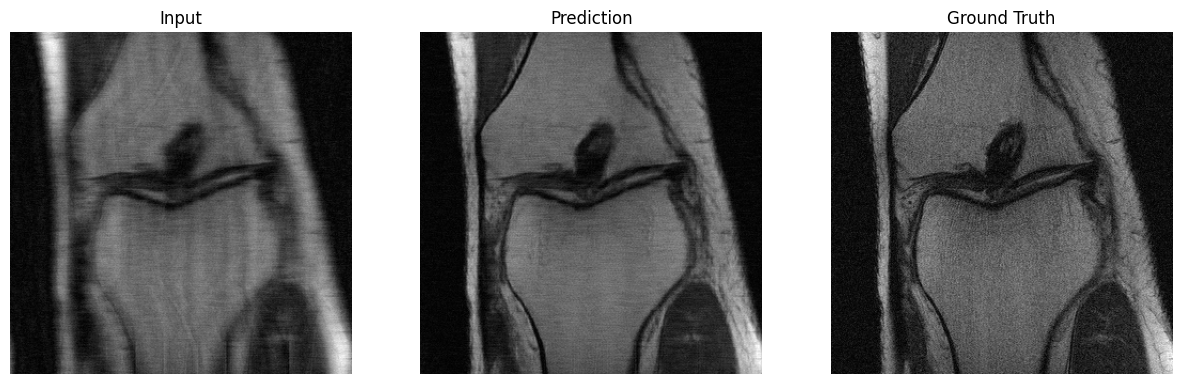

In [32]:
if is_skip_training:
    model.load_state_dict(torch.load(pretrained_model_path))
    print(f"Pretrained weight loaded from {pretrained_model_path}")

# Validation
metrics_dict = validate(model, test_loader)

val_ssim = np.mean(metrics_dict['ssim'])
val_psnr = np.mean(metrics_dict['psnr'])
val_ssim_zf = np.mean(metrics_dict['ssim_zf'])
val_psnr_zf = np.mean(metrics_dict['psnr_zf'])

print(f"Validation SSIM: {val_ssim:.4f}")
print(f"Validation PSNR: {val_psnr:.4f}")
print(f"Validation SSIM (ZF): {val_ssim_zf:.4f}")
print(f"Validation PSNR (ZF): {val_psnr_zf:.4f}")

# Plot
validate_one_step(model, test_loader)


## Training an GAN-based MRI Reconstruction Model

Generative Adversarial Networks (GANs) have been increasingly employed for MRI reconstruction tasks to improve perceptual quality and restore high-frequency details. This section outlines the key components, data handling, and training process for a GAN-based reconstruction model.

In a GAN-based MRI reconstruction pipeline, there are two neural networks working in tandem: the generator and the discriminator.

- **Generator:** The generator aims to reconstruct fully sampled MRI images from undersampled inputs. It takes undersampled k-space or image domain data as input and outputs a reconstructed image. Common architectures for the generator include U-Net, ResNet, or their variants, designed to handle complex-valued MRI data.

- **Discriminator:** The discriminator distinguishes between the reconstructed images (generated by the generator) and the ground truth fully sampled images. It is typically implemented as a convolutional neural network (CNN) that outputs a probability score indicating whether an image is real (ground truth) or fake (generated).

The input and target data for training the GAN-based MRI reconstruction model are similar to the end-to-end models:

- **Input:** Similar to other MRI reconstruction models, the input consists of undersampled k-space data or image domain representations, often separated into real and imaginary channels for complex-valued data.

- **Target:** The ground truth is the fully sampled image or k-space data, also represented in real and imaginary channels.

The training objective involves two loss components:

- **Reconstruction Loss:** This ensures the generator outputs are close to the ground truth. Common choices include L1 loss, L2 loss, or SSIM-based loss.
- **Adversarial Loss:** This encourages the generator to produce outputs indistinguishable from real images, optimized based on feedback from the discriminator.

The interplay between the generator and discriminator during training creates a competitive dynamic, helping the generator learn to produce high-quality reconstructed MRI images.

### Delete the previous variables


In [33]:
del model, optimizer, train_dataset, test_dataset, train_loader, test_loader, loss_fn
del metrics_dict, val_ssim, val_psnr, val_psnr_zf, val_ssim_zf
del train_losses_over_epochs, train_losses_over_steps

### Parameters


In [34]:
# Parameters

## Task 
generator_name = 'unet'
# generator_name = 'unet_resi'
discriminator_name = 'unet'
# discriminator_name = 'vgg'
model_name = 'unet_gan'
mask_name = 'fMRI_Reg_AF4_CF0.08_PE320'

is_debug = False
is_save_models = True
is_save_all_models = False
is_skip_training = False
pretrained_generator_path = None
# pretrained_generator_path = '/home/jh/simple_mri_recon/runs/unet_gan_fMRI_Reg_AF4_CF0.08_PE320/unet_gan.pth'

task_name = '{}_{}'.format(model_name, mask_name) if not is_debug else 'tmp'
save_path = os.path.join('runs', task_name)

## Dataset
train_path = 'dataset/fastmri_tiny/train'
test_path = 'dataset/fastmri_tiny/val'
train_batch_size = 4
test_batch_size = 1

## Model
in_channels = 2
out_channels = 2

## Optimisation
total_epochs = 100
lr_G = 1e-4
lr_D = 1e-4

## Parameter check
assert is_skip_training == (pretrained_generator_path is not None)  # is_skip_training implies pretrained_generator_path is not None
assert not is_save_all_models or is_save_models  # is_save_all_models implies is_save_models


### Define Network


In [35]:
class Discriminator_UNet(nn.Module):
    """Defines a U-Net discriminator with spectral normalization (SN)"""

    def __init__(self, input_nc=3, ndf=64):
        super(Discriminator_UNet, self).__init__()

        norm = spectral_norm

        self.conv0 = nn.Conv2d(input_nc, ndf, kernel_size=3, stride=1, padding=1)

        self.conv1 = norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False))
        self.conv2 = norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False))
        self.conv3 = norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False))
        # upsample
        self.conv4 = norm(nn.Conv2d(ndf * 8, ndf * 4, 3, 1, 1, bias=False))
        self.conv5 = norm(nn.Conv2d(ndf * 8, ndf * 2, 3, 1, 1, bias=False))
        self.conv6 = norm(nn.Conv2d(ndf * 4, ndf, 3, 1, 1, bias=False))

        # extra
        self.conv7 = norm(nn.Conv2d(ndf * 2, ndf, 3, 1, 1, bias=False))
        self.conv8 = norm(nn.Conv2d(ndf, ndf, 3, 1, 1, bias=False))

        self.conv9 = nn.Conv2d(ndf, 1, 3, 1, 1)

    def forward(self, x):
        x0 = F.leaky_relu(self.conv0(x), negative_slope=0.2, inplace=True)
        x1 = F.leaky_relu(self.conv1(x0), negative_slope=0.2, inplace=True)
        x2 = F.leaky_relu(self.conv2(x1), negative_slope=0.2, inplace=True)
        x3 = F.leaky_relu(self.conv3(x2), negative_slope=0.2, inplace=True)

        # upsample
        x3 = F.interpolate(x3, scale_factor=2, mode='bilinear', align_corners=False)
        x4 = F.leaky_relu(self.conv4(x3), negative_slope=0.2, inplace=True)

        # 256 + 256 --> 512
        x4 = torch.cat([x4, x2], dim=1)
        x4 = F.interpolate(x4, scale_factor=2, mode='bilinear', align_corners=False)
        x5 = F.leaky_relu(self.conv5(x4), negative_slope=0.2, inplace=True)

        # 128 + 128 --> 256
        x5 = torch.cat([x5, x1], dim=1)
        x5 = F.interpolate(x5, scale_factor=2, mode='bilinear', align_corners=False)
        x6 = F.leaky_relu(self.conv6(x5), negative_slope=0.2, inplace=True)

        # 64 + 64 --> 128
        x6 = torch.cat([x6, x0], dim=1)

        # extra
        out = F.leaky_relu(self.conv7(x6), negative_slope=0.2, inplace=True)
        out = F.leaky_relu(self.conv8(out), negative_slope=0.2, inplace=True)
        out = self.conv9(out)

        return out


In [36]:
# Network selection
def define_generator(model_name):

    if model_name == 'unet':
        model_type = UNet
    elif model_name == 'unet_resi':
        model_type = UNet_resi
    else:
        raise NotImplementedError
    
    return model_type


# Network selection
def define_discriminator(model_name):

    if model_name == 'unet':
        model_type = Discriminator_UNet
    elif model_name == 'vgg':
        raise NotImplementedError
    else:
        raise NotImplementedError
    
    return model_type

In [37]:
# Load the model
generator_type = define_generator(generator_name)
discriminator_type = define_discriminator(discriminator_name)

# Instantiate the model
generator = generator_type(in_channels=in_channels, out_channels=out_channels).to(device)
discriminator = discriminator_type(input_nc=in_channels, ndf=64).to(device)


### Define Dataloader


In [38]:
# Training and testing dataloaders
train_dataset = DatasetFastMRI(data_path_src=train_path, mask_name=mask_name, is_debug=is_debug)
test_dataset = DatasetFastMRI(data_path_src=test_path, mask_name=mask_name, is_debug=is_debug)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=False)


### Define Loss Function


In [39]:
# Define loss function
loss_fn_recon = partial(total_loss, 
                        loss_image_weight=15,
                        loss_image_type='l1',
                        loss_freq_weight=0.1, 
                        loss_freq_type='l1',
                        device=device)

loss_fn_adv = nn.BCEWithLogitsLoss().to(device)


### Define Optimisation Setting


In [40]:
# Define optimizer
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_G)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_D)

### Training Loop


In [41]:
# Training for one epoch
def train_gan_one_epoch(generator, discriminator, dataloader, optimizer_G, optimizer_D, loss_fn_recon, loss_fn_adv, epoch, total_epochs, loss_g_weight=1, loss_d_weight=0.1):
    generator.train()
    discriminator.train()
    total_loss_G = 0
    total_loss_D_real = 0
    total_loss_D_fake = 0
    all_batch_losses_G = []
    all_batch_losses_D_real = []
    all_batch_losses_D_fake = []

    for batch in tqdm(dataloader, desc=f"Training Epoch {epoch+1}/{total_epochs}", leave=False):
        input, gt = batch
        input, gt = input.to(device), gt.to(device)
        
        # Train the generator
        
        # D: Freeze
        for p in discriminator.parameters():
            p.requires_grad = False
        # G: Zero grad
        optimizer_G.zero_grad()
        # G: Forward pass
        pred = generator(input)
        # D: Forward pass
        pred_g_fake = discriminator(pred)
        # G: Loss
        loss_adversarial = loss_fn_adv(pred_g_fake, torch.ones_like(pred_g_fake))  # vs True
        loss_recon = loss_fn_recon(pred, gt)
        loss_g_total = loss_g_weight * loss_recon + loss_d_weight * loss_adversarial
        # G: Backward pass
        loss_g_total.backward()
        optimizer_G.step()

        # Train the discriminator
        
        # D: Unfreeze
        for p in discriminator.parameters():
            p.requires_grad = True
        # D: Zero grad
        optimizer_D.zero_grad()
        # D: Forward pass
        pred_d_real = discriminator(gt)  # real data
        pred_d_fake = discriminator(pred.detach().clone()) # fake data, detach to avoid BP to generator
        # D: Loss
        loss_d_real = loss_fn_adv(pred_d_real, torch.ones_like(pred_d_real))  # vs True
        loss_d_fake = loss_fn_adv(pred_d_fake, torch.zeros_like(pred_d_fake))  # vs False
        # D: Backward pass
        loss_d_real.backward()
        loss_d_fake.backward()
        optimizer_D.step()

        total_loss_G += loss_g_total.item()
        total_loss_D_real += loss_d_real.item()
        total_loss_D_fake += loss_d_fake.item()
        all_batch_losses_G.append(loss_g_total.item())
        all_batch_losses_D_real.append(loss_d_real.item())
        all_batch_losses_D_fake.append(loss_d_fake.item())
    return total_loss_G / len(dataloader), total_loss_D_real / len(dataloader), total_loss_D_fake / len(dataloader), all_batch_losses_G, all_batch_losses_D_real, all_batch_losses_D_fake   



Start training


Training Completed


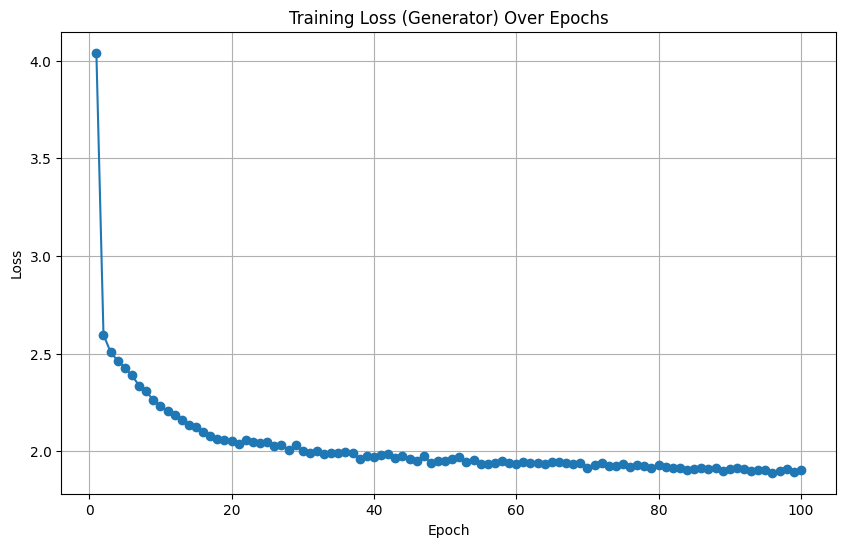

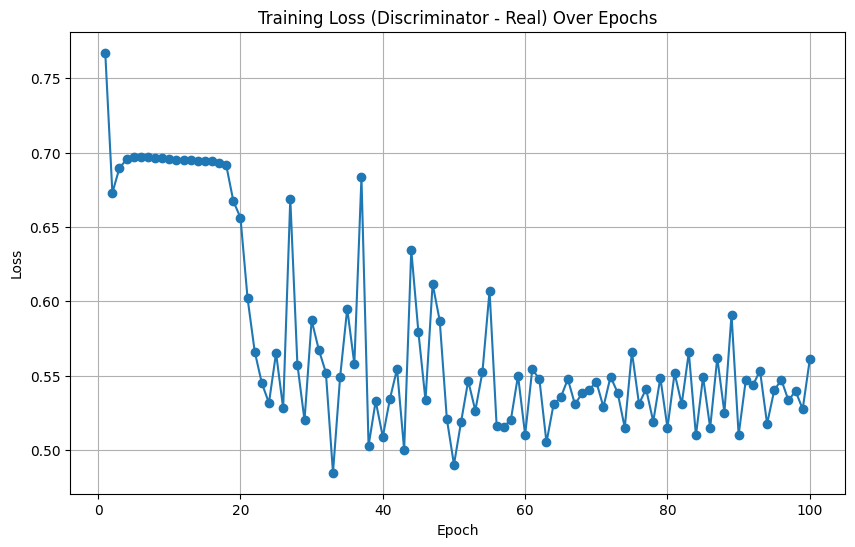

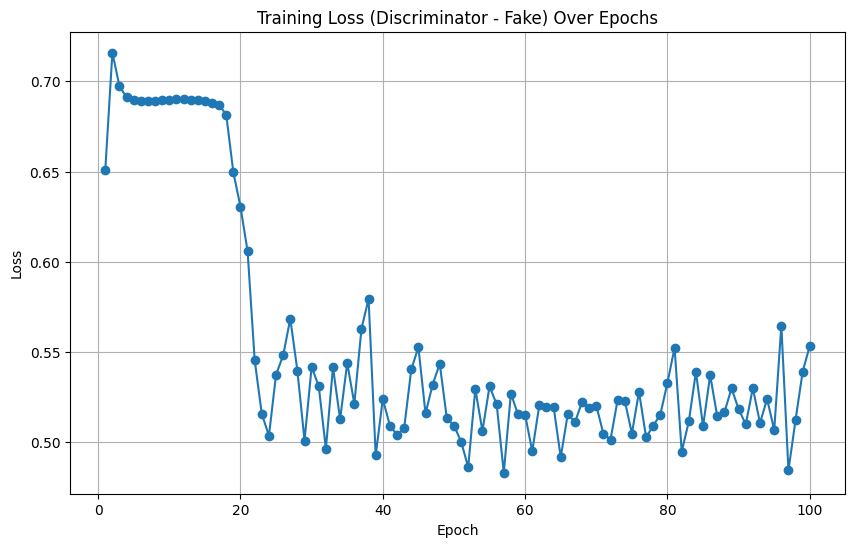

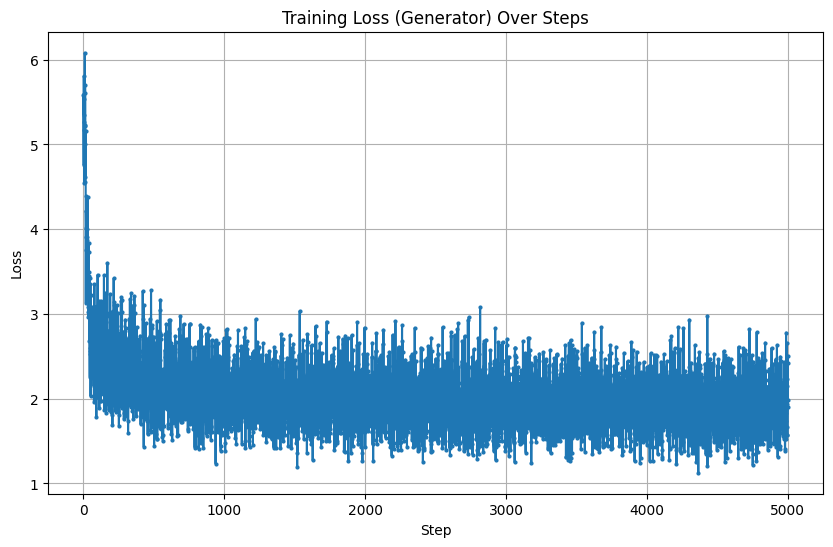

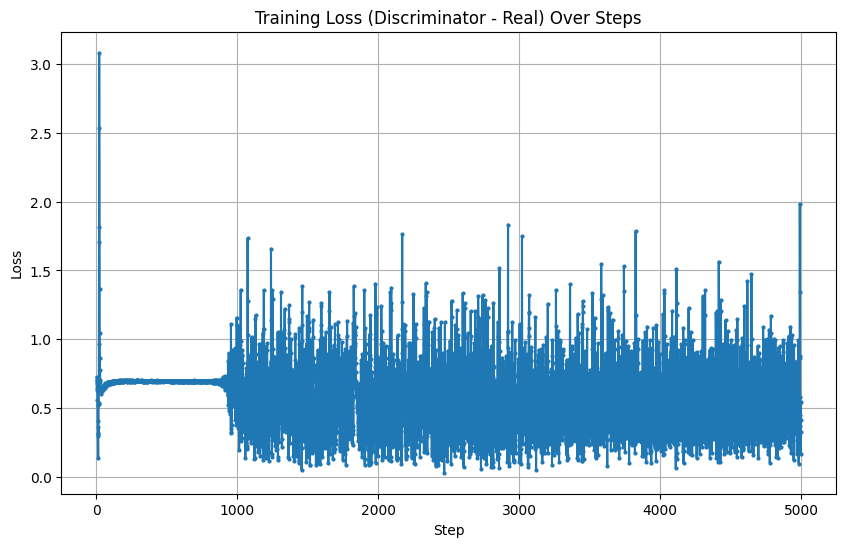

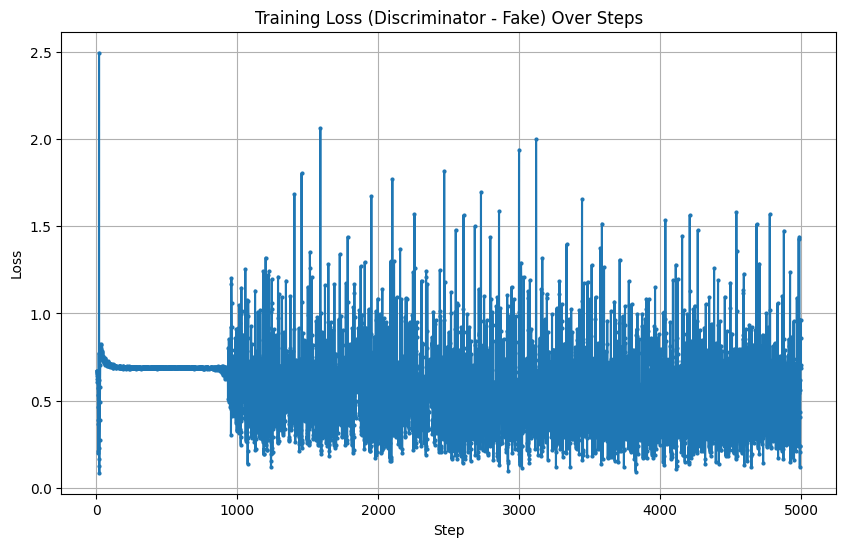

In [42]:
# Skip training
if is_skip_training:
    print("Skip training")
else:
    print("Start training")

    train_losses_G_over_epochs = []
    train_losses_G_over_steps = []
    train_losses_D_real_over_epochs = []
    train_losses_D_real_over_steps = []
    train_losses_D_fake_over_epochs = []
    train_losses_D_fake_over_steps = []
    
    # Training loop
    for epoch in range(total_epochs):
        # print(f"Epoch {epoch+1}")
        train_loss_G, train_loss_D_real, train_loss_D_fake, batch_losses_G, batch_losses_D_real, batch_losses_D_fake = train_gan_one_epoch(generator, discriminator, train_loader, optimizer_G, optimizer_D, loss_fn_recon, loss_fn_adv, epoch, total_epochs)
        train_losses_G_over_epochs.append(train_loss_G)
        train_losses_G_over_steps.extend(batch_losses_G)
        train_losses_D_real_over_epochs.append(train_loss_D_real)
        train_losses_D_real_over_steps.extend(batch_losses_D_real)
        train_losses_D_fake_over_epochs.append(train_loss_D_fake)
        train_losses_D_fake_over_steps.extend(batch_losses_D_fake)
        
        # save model
        mkdir(save_path)
        if is_save_models:
            torch.save(generator.state_dict(), os.path.join(save_path, f"{model_name}.pth"))
            if is_save_all_models:
                torch.save(generator.state_dict(), os.path.join(save_path, f"{model_name}_{epoch+1}.pth"))
    
    print("Training Completed")
    
    # Plot training loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses_G_over_epochs) + 1), train_losses_G_over_epochs, marker='o')
    plt.title("Training Loss (Generator) Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses_D_real_over_epochs) + 1), train_losses_D_real_over_epochs, marker='o')
    plt.title("Training Loss (Discriminator - Real) Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses_D_fake_over_epochs) + 1), train_losses_D_fake_over_epochs, marker='o')
    plt.title("Training Loss (Discriminator - Fake) Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()
    
    # Plot training loss over steps
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses_G_over_steps) + 1), train_losses_G_over_steps, marker='o', markersize=2)
    plt.title("Training Loss (Generator) Over Steps")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses_D_real_over_steps) + 1), train_losses_D_real_over_steps, marker='o', markersize=2)
    plt.title("Training Loss (Discriminator - Real) Over Steps")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses_D_fake_over_steps) + 1), train_losses_D_fake_over_steps, marker='o', markersize=2)
    plt.title("Training Loss (Discriminator - Fake) Over Steps")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()
    

### Inference

In [43]:
# Validation for testset
def validate(model, dataloader):
    model.eval()

    metrics_dict = {}
    metrics_dict['ssim'] = []
    metrics_dict['psnr'] = []
    metrics_dict['ssim_zf'] = []
    metrics_dict['psnr_zf'] = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation", leave=False):
            input, gt = batch
            input, gt = input.to(device), gt.to(device)
            pred = model(input)

            input = torch.abs(torch.complex(input[:, :1, ...], input[:, 1:, ...]))
            pred = torch.abs(torch.complex(pred[:, :1, ...], pred[:, 1:, ...]))
            gt = torch.abs(torch.complex(gt[:, :1, ...], gt[:, 1:, ...]))
            
            input = input.squeeze().float().cpu().numpy()
            pred = pred.data.squeeze().float().cpu().numpy()
            gt = gt.data.squeeze().float().cpu().numpy()
            
            ssim = calculate_ssim_single(pred, gt, data_range=gt.max())
            psnr = calculate_psnr_single(pred, gt, data_range=gt.max())
            metrics_dict['ssim'].append(ssim)
            metrics_dict['psnr'].append(psnr)
            
            ssim_zf = calculate_ssim_single(input, gt, data_range=gt.max())
            psnr_zf = calculate_psnr_single(input, gt, data_range=gt.max())
            metrics_dict['ssim_zf'].append(ssim_zf)
            metrics_dict['psnr_zf'].append(psnr_zf)
            
    return metrics_dict


# Validation for one step (plotting)
def validate_one_step(model, dataloader):
    model.eval()

    with torch.no_grad():
        batch = next(iter(dataloader))  # Load the first batch
        x, y = batch
        x, y = x.to(device), y.to(device)
        pred = model(x)

        # Visualize the first sample in the batch
        input_image = torch.abs(torch.complex(x[0, 0, :, :], x[0, 1, :, :])).cpu().numpy()
        ground_truth = torch.abs(torch.complex(y[0, 0, :, :], y[0, 1, :, :])).cpu().numpy()
        predicted_image = torch.abs(torch.complex(pred[0, 0, :, :], pred[0, 1, :, :])).cpu().numpy()

        plt.figure(figsize=(15, 5))

        # Input
        plt.subplot(1, 3, 1)
        plt.imshow(input_image, cmap='gray')
        plt.title("Input")
        plt.axis('off')

        # Prediction
        plt.subplot(1, 3, 2)
        plt.imshow(predicted_image, cmap='gray')
        plt.title("Prediction")
        plt.axis('off')
        
        # Ground Truth
        plt.subplot(1, 3, 3)
        plt.imshow(ground_truth, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')
        plt.show()


Validation SSIM: 0.6733
Validation PSNR: 28.5641
Validation SSIM (ZF): 0.6066
Validation PSNR (ZF): 26.1458


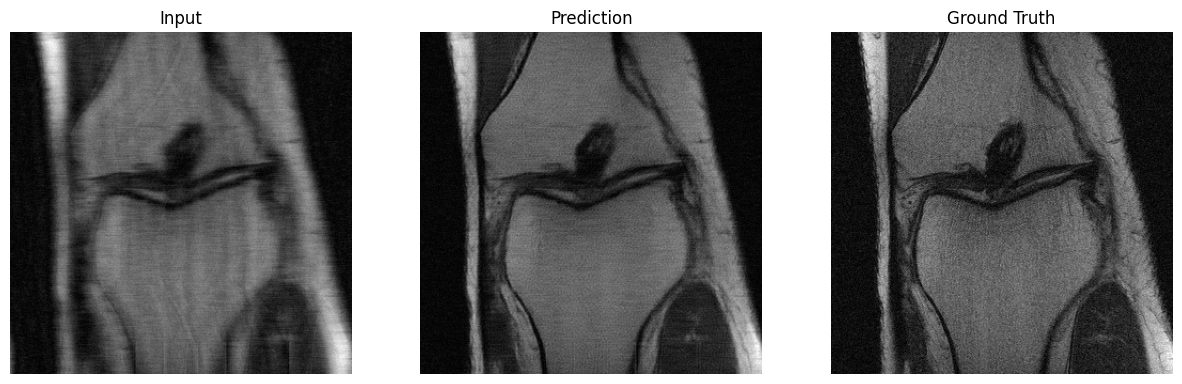

In [44]:
if is_skip_training:
    generator.load_state_dict(torch.load(pretrained_generator_path))
    print(f"Pretrained weight loaded from {pretrained_generator_path}")

# Validation
metrics_dict = validate(generator, test_loader)

val_ssim = np.mean(metrics_dict['ssim'])
val_psnr = np.mean(metrics_dict['psnr'])
val_ssim_zf = np.mean(metrics_dict['ssim_zf'])
val_psnr_zf = np.mean(metrics_dict['psnr_zf'])

print(f"Validation SSIM: {val_ssim:.4f}")
print(f"Validation PSNR: {val_psnr:.4f}")
print(f"Validation SSIM (ZF): {val_ssim_zf:.4f}")
print(f"Validation PSNR (ZF): {val_psnr_zf:.4f}")

# Plot
validate_one_step(generator, test_loader)
